# Lockdown baking - part 2

A project for scraping and analysing data from reddit (r/Sourdough) to explore baking trends during 2020.

Part 2: Data cleaning and classification

# Setup

In [1]:
## set root folder
import os 
os.chdir("..")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import calplot #to make calendar heat map

%matplotlib inline

# Clean data

## Load data

In [3]:
#load scraped datafiles
df = pd.read_csv(".\\data\scraped\post_df_2021-01-07.csv")

In [4]:
# explore shape and columns
print(df.shape)
print(df.columns)
print("")
print(df.head(3))

(41309, 8)
Index(['Unnamed: 0', 'id', 'score', 'created_utc', 'title', 'num_comments',
       'can_mod_post', 'author'],
      dtype='object')

   Unnamed: 0      id  score  created_utc  \
0           0  eibhvl      1   1577839131   
1           1  eibvur      1   1577841129   
2           2  eiby7m      1   1577841483   

                                               title  num_comments  \
0  First attempt at a starter, really hope I mana...             5   
1  Skillet &amp; Dutch Oven Sourdough in the rain...             0   
2  My last bread of 2019. I used Brad and Claire’...             0   

   can_mod_post         author  
0         False  coentertainer  
1         False     Richness69  
2         False     canioli019  


## Remove unnecessary data

In [5]:
print(df["can_mod_post"].value_counts()) 

#since there are no moderators, we don't need this variable
df = df.drop(columns=["can_mod_post"])

#check if column has been removed correctly
print(df.columns)

False    41309
Name: can_mod_post, dtype: int64
Index(['Unnamed: 0', 'id', 'score', 'created_utc', 'title', 'num_comments',
       'author'],
      dtype='object')


## Derive date and time variables

In [6]:
from datetime import datetime

# derive datetime from unix timestamp
df["created"] = pd.to_datetime(df["created_utc"], unit = 's')

#derive month from datetime
df["created_month"] = pd.DatetimeIndex(df["created"]).month
df["created_month_label"] = df["created_month"].map({1: "January", 2: "February", 3:"March", 4:"April", 5:"May",
                                                    6:"June", 7:"July", 8:"August", 9:"September", 10:"October",
                                                    11:"November", 12: "December"})

#derive day from datetime
df["created_short"] = df.created.dt.strftime("%Y-%m-%d")

#derive weekday from datetime
weekday_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3:"Thursday", 4: "Friday", 5:"Saturday", 6:"Sunday"}
df["created_weekday"] = pd.DatetimeIndex(df["created"]).weekday

#derive hour from datetime
df["created_hour"] = pd.DatetimeIndex(df["created"]).hour

#derive week number from datetime
df["created_week"] = pd.DatetimeIndex(df["created"]).week

<ipython-input-6-a0622d61cd99>:23: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["created_week"] = pd.DatetimeIndex(df["created"]).week


## Title

We need to clean the text data in the title so that we can do some proper text mining. This includes

- Standardising
- Tokenising and removing stop words
- Lemmatising





### Standardising

We will remove punctuation and clean any other symbols/words as needed.

In [145]:
# make titles lower case
title = df["title"].str.lower()

# replace values within titles

# function to loop through the column and replace substrings
def replace_values(text, dic):
    for x, y in dic.items():
        text = text.str.replace(x, y, regex=True)
    return text

# list of values to be replaced, including punctuation
replace_dict = {"&amp;": " ", #xml syntax for &
                "[!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-]": " ",
                "pnw" : "pacific northwest",
                "  ": " ", #double space
                "’s" :"",  
                "’m" : "",
                "y'all": "you all",
                "i'm": "i am",
                "i've": "i have",
                "it'll": "it will",
                "we're": "we are",
                "i'd": "i would",
                "loaves": "loaf"
               }
                
# apply function
title = replace_values(title, replace_dict)

# strip white space at the end
title = title.str.strip()

# add new column to dataframe
df["title_standardised"] = title

print(title)

0        first attempt at a starter really hope i manag...
1        skillet  dutch oven sourdough in the rainy pac...
2        my last bread of 2019 i used brad and claire r...
3        this bread came out really nice i just have a ...
4        i started baking in september and i have never...
                               ...                        
40510    such a sense of pride seeing it double winter ...
40511                                        starter in la
40512                               honey walnut sourdough
40513    got my first starter last week as a christmas ...
40514               last 2020 feeding for dame judi stench
Name: title, Length: 40515, dtype: object


### Remove stop words

We now remove stop words that don't really help to identify the sentiment or topic of a sentence. 

In [8]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [146]:
# create empty list to store titles without stop words
title_no_stop_words = []

# iterate through each word in each title and append those that are no stop words
# split titles into substrings using space as delimiter
for words in title.str.split(" "):
    x = []
    for word in words:
        if word not in stop_words:
            x.append(word)
    title_no_stop_words.append(x)

# join titles back together
title_no_stop_words = [" ".join(items) for items in title_no_stop_words]

# add title to dataframe
df["title_no_stop_words"] = title_no_stop_words

print(title_no_stop_words[:10])

['first attempt starter really hope manage keep alive mixed existence opening second decade', 'skillet  dutch oven sourdough rainy pacific northwest', 'last bread 2019 used brad claire recipe alive sourdough starter smelled bit sweet weird bread turned good anyways', 'bread came really nice problem oval shape proofing basket vs shape dutch oven loaf long fit properly one side gets ugly shape tips avoiding flat loaf baking without get round baskets', 'started baking september never happier decision may new year bring happy starters crackly crusts', 'wow love bread', 'advice suggestions would greatly appreciated', 'yeehaw finally got decent ear', 'honey rye sandwich bread absolutely blew oven', 'finally month long slump pancake loaf beauty came oven yesterday']


### Lemmatize
Now we want to reduce the inflectional forms of each word into a common base or root. We do this by using a lemmatiser that detects the lemma for each word. 

Read [this article](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/) for more information on the difference betweent stemmatising and lemmatising. 

In [147]:
import en_core_web_sm

# load model from SpaCy
nlp = en_core_web_sm.load()

# create new list to store lemmatised titles
title_lemmatised = []

# iterate through each word in each title and append the lemmatised version of the word
for words in pd.Series(title_no_stop_words):
    x = []
    for word in nlp(words):
        x.append(word.lemma_)
    title_lemmatised.append(x)

# join titles back together
title_lemmatised = [" ".join(items) for items in title_lemmatised]

df["title_lemmatised"] = title_lemmatised

## Remove duplicates

In [141]:
# detect duplicates based on author and title standardised
print("Number of duplicate rows: ",len(df[df[["author", "title_standardised"]].duplicated(keep="last")]))

#remove duplicates and reset index
df = df.drop_duplicates(subset=["author", "title_standardised"],keep="last").reset_index(drop=True) #data ordered by date, last = latest
print("New number of rows: ", len(df))

Number of duplicate rows:  0
New number of rows:  40515


## User group

In [15]:
# count number of posts by author and put them into groups
bins = [0, 1, 2, 5, 10, 50, np.inf]
bin_labels = ["1", "2", "3-5", "6-10", "11-50","Over 50"]

pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot['posts_by_user'] = pd.cut(pivot['id'], bins, labels=bin_labels)
pivot = pivot.reset_index().drop(columns="id")

# add column to dataframe based on number of posts by author as 'user group'
df = pd.merge(df, pivot, left_on="author", right_on="author")

#print head
df.head()

,Unnamed: 0,id,score,created_utc,title,num_comments,author,created,created_month,created_month_label,created_short,created_weekday,created_hour,created_week,title_standardised,title_no_stop_words,title_lemmatised,posts_by_user
0,0,eibhvl,1,1577839131,"First attempt at a starter, really hope I mana...",5,coentertainer,2020-01-01 00:38:51,1,January,2020-01-01,2,0,1,first attempt at a starter really hope i manag...,first attempt starter really hope manage keep ...,first attempt starter really hope manage keep ...,1
1,1,eibvur,1,1577841129,Skillet &amp; Dutch Oven Sourdough in the rain...,0,Richness69,2020-01-01 01:12:09,1,January,2020-01-01,2,1,1,skillet dutch oven sourdough in the rainy paci...,skillet dutch oven sourdough rainy pacific nor...,skillet dutch oven sourdough rainy pacific nor...,1
2,2,eiby7m,1,1577841483,My last bread of 2019. I used Brad and Claire’...,0,canioli019,2020-01-01 01:18:03,1,January,2020-01-01,2,1,1,my last bread of 2019 i used brad and claire r...,last bread 2019 used brad claire recipe alive ...,last bread 2019 use brad claire recipe alive s...,2
3,276,ektkdp,1,1578313987,"This bread came out really nice, I just have a...",11,canioli019,2020-01-06 12:33:07,1,January,2020-01-06,0,12,2,this bread came out really nice i just have a ...,bread came really nice problem oval shape proo...,bread come really nice problem oval shape proo...,2
4,3,eictkk,1,1577846281,I started baking in September and I have never...,0,singular-chip,2020-01-01 02:38:01,1,January,2020-01-01,2,2,1,i started baking in september and i have never...,started baking september never happier decisio...,start bake september never happy decision may ...,6-10


## Moderator

In [93]:
## Moderator
df["moderator"] = 0
df.loc[df["author"] == "phil_s_stein", "moderator"] = 1
df.loc[df["author"] == "AutoModerator", "moderator"] = 1

## Export cleaned dataframe

In [143]:
#load scraped datafiles
df.to_csv(".\\data\processed\df-for-analysis_2021-02-14.csv")

In [4]:
## load processed data file
df = pd.read_csv(".\\data\processed\df-for-analysis_2021-02-14.csv")

In [12]:
df["title_lemmatised"] = df["title_lemmatised"].astype(str)

# Analysis

## Filter

In [100]:
mod_filter = (df["moderator"]==0)

## Engagement over time

In [101]:
## Submissions and comments by month
pivot = df.groupby("created_month")[["id", "num_comments", "author"]].agg({"id": "count",
                                                                             "num_comments":"sum",
                                                                            "author": "nunique"})
pivot.loc['Total'] = [df["id"].count(), df["num_comments"].sum(), df["author"].nunique()] #add total row
pivot

,num_comments,id,author
created_month,,,
1,14992,2869,1024
2,15855,3109,1023
3,28078,7811,2155
4,53596,17975,4739
5,50151,13805,4293
6,31886,6993,2780
7,29536,5836,2285
8,18237,4751,1846
9,13963,3281,1440


<AxesSubplot:xlabel='created_month'>

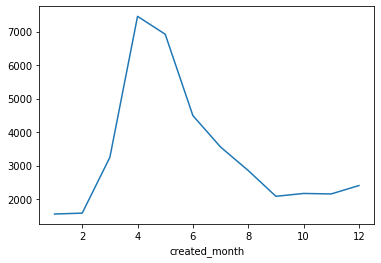

In [20]:
df.groupby("created_month")["id"].count().plot(kind='line')

<AxesSubplot:xlabel='created_month'>

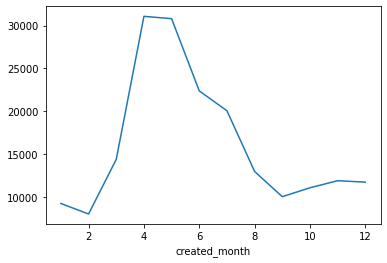

In [21]:
df.groupby("created_month")["num_comments"].sum().plot(kind='line')

### Summary by weekday

In [25]:
## Submissions and comments by weekday
pivot = df.groupby("created_weekday")[["id", "num_comments", "author"]].agg({"id": "count",
                                                                             "num_comments":"sum",
                                                                            "author": "nunique"})

pivot.loc['Total'] = [df["id"].count(), df["num_comments"].sum(), df["author"].nunique()] #add total row
pivot

,id,num_comments,author
created_weekday,,,
0,5954,26317,4331
1,5347,29306,4012
2,5497,29137,4059
3,5202,26702,3881
4,5153,26865,3927
5,6097,26665,4310
6,7265,28939,4945
Total,40515,193931,16865


### summary by month

In [18]:
df2 = df[["created_month", "created_month_label", "author", "num_comments"]]

df2 = df2.groupby('created_month', as_index=True).agg({'created_month_label': 'first',
                                                       'author': ["nunique", 'count'],
                                                       'num_comments': ['sum', 'max'] 
                                                      })
df2.columns = df2.columns.droplevel(level=0)
df2 = df2.reset_index().rename(columns={"created_month":"month", 
                                        "nunique":"unique_user", 
                                        "count": "no_of_submissions", 
                                        "sum":"total_comments",
                                       "max": "max_comments",
                                       "first": "month_label"})

# create metrics per user
df2["submission_per_user"] = df2["no_of_submissions"] / df2["unique_user"] 
df2["comments_per_submission"] = df2["total_comments"] / df2["no_of_submissions"] 

#save output
df2.to_csv(".\\data\charts\overview_by_month.csv", index=False)

df2

,month,month_label,unique_user,no_of_submissions,total_comments,max_comments,submission_per_user,comments_per_submission
0,1,January,1024,1560,9273,112,1.523438,5.944231
1,2,February,1023,1586,8046,63,1.550342,5.073140
2,3,March,2155,3252,14414,143,1.509049,4.432349
3,4,April,4739,7456,31076,951,1.573328,4.167918
4,5,May,4293,6922,30804,955,1.612392,4.450159
5,6,June,2780,4495,22387,619,1.616906,4.980423
6,7,July,2285,3558,20077,619,1.557112,5.642777
7,8,August,1846,2857,13000,216,1.547671,4.550228
8,9,September,1440,2088,10066,204,1.450000,4.820881
9,10,October,1474,2173,11101,199,1.474220,5.108606


## Calendar heatmap

Using [calplot](https://calplot.readthedocs.io/en/latest/). 

(<Figure size 900x122.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='2020'>], dtype=object))

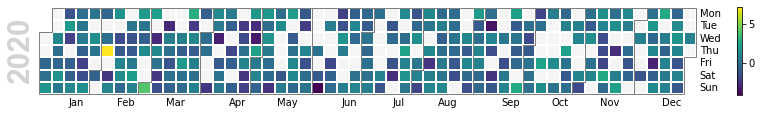

In [14]:
# example code
import calplot
import numpy as np; np.random.seed(sum(map(ord, 'calplot')))


all_days = pd.date_range('1/1/2020', periods=365, freq='D')
days = np.random.choice(all_days, 500)
events = pd.Series(np.random.randn(len(days)), index=days)
calplot.calplot(events)

### Comments

array([<AxesSubplot:ylabel='2020'>], dtype=object)

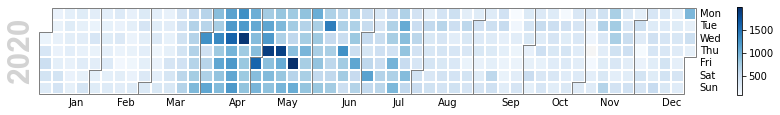

In [22]:
all_days = pd.date_range('1/1/2020', periods=366, freq='D')
events = df.groupby("created_short")["num_comments"].sum()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues')

fig[1]

<AxesSubplot:xlabel='created_month'>

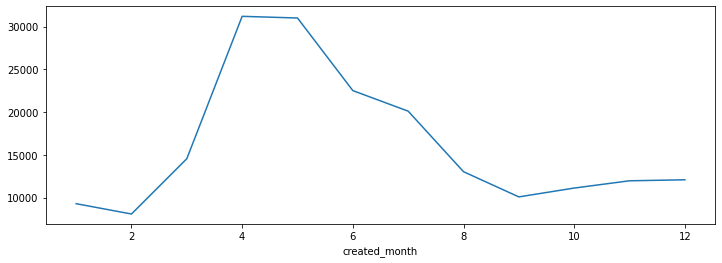

In [59]:
df.groupby("created_month")["num_comments"].sum().plot(kind='line', figsize=(12,4))

### Posts

array([<AxesSubplot:ylabel='2020'>], dtype=object)

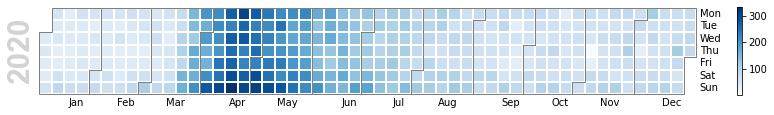

In [23]:
all_days = pd.date_range('1/1/2020', periods=366, freq='D')
events = df.groupby("created_short")["id"].count()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues')

fig[1]

<AxesSubplot:xlabel='created_month'>

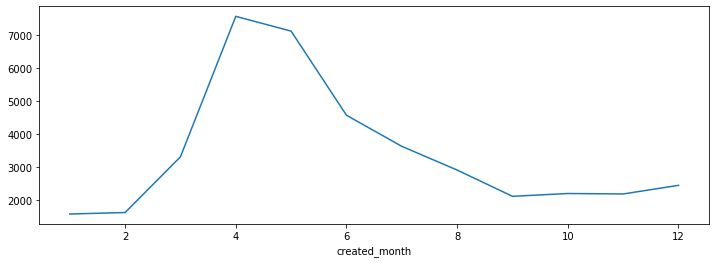

In [57]:
df.groupby("created_month")["id"].count().plot(kind='line', figsize=(12,4))

## Comments

In [131]:
df["num_comments"].median()

2.0

In [130]:
# number of posts with no comments

df.loc[df["num_comments"]==0]["num_comments"].value_counts() / len(df) *100

0    29.988893
Name: num_comments, dtype: float64

In [83]:
#look at posts with highest number of comments
comments = df[["title_lemmatised", "created_month_label", "num_comments", "author"]].sort_values(by="num_comments", ascending=False).head(30)

#save output
comments.to_csv(".//data/charts/top30-posts-by-comments.csv", index=False)

#display
comments

,title_lemmatised,created_month_label,num_comments,author
27307,weekly open sourdough question discussion post...,May,955,phil_s_stein
27301,open sourdough question discussion post apri...,April,951,phil_s_stein
27304,open sourdough question discussion post may 7th,May,945,phil_s_stein
27306,weekly open sourdough question discussion post...,May,881,phil_s_stein
27303,open sourdough question discussion post may 1st,May,821,phil_s_stein
27313,weekly open sourdough question discussion post...,July,619,phil_s_stein
27309,weekly open sourdough question discussion post...,June,619,phil_s_stein
27291,general r sourdough discussion post april 15th,April,525,phil_s_stein
27308,weekly open sourdough question discussion post...,June,494,phil_s_stein
27310,weekly open sourdough question discussion post...,June,474,phil_s_stein


In [129]:
#look at posts with highest number of comments
comments = df.loc[mod_filter][["title_x", "created_month_label", "num_comments", "author"]].sort_values(by="num_comments", ascending=False).head(30)

#save output
comments.to_csv(".//data/charts/top30-posts-by-comments-without-moderator.csv", index=False)

#display
comments

,title_x,created_month_label,num_comments,author
78484,Starter name sharing time I’ll start,December,356,kagadee
56052,"Unpopular Opinion: if you like your crumb, it'...",May,265,UnicornToots
28595,I made a sourdough baking app!,July,261,jscalo
31444,Just a video of le me shaping a 92% hydration ...,June,233,the_bread_code
61519,I’m enjoying bread making so much that I’ve ap...,July,220,ChickenBunch
63439,Here’s another video of me shaping sourdough. ...,May,216,delphinethebaker
54820,Guinness stouterdough bread. 100% of water sub...,June,193,BeardBeardBabyDunDun
77155,"The oven spring, the crumb, just mwah👌",November,187,PMme_slave_leia_pics
71910,"Contrary to popular belief, it's entirely poss...",July,187,kaspervb99
55982,I almost cried earlier today,April,183,Lt_DansNewLegs


### Number of comments by type of user

In [128]:
pivot = df.loc[df["moderator"]==0].groupby(["posts_by_user"]).agg({'num_comments': ["sum", "mean", "max"]})
pivot

num_comments               
                       sum      mean  max
posts_by_user                            
1                    38157  3.972618  356
11-50                33258  5.166693  265
2                    28146  4.447851  173
3-5                  46616  4.498311  216
6-10                 31175  4.750838  187
Over 50               4463  3.791844  233

## Number of users

### overview

In [64]:
df2 = df[["created_month", "author", "num_comments"]]

df2 = df2.groupby('created_month', as_index=True).agg({'author': [pd.Series.nunique, 'count'],
                                                                               'num_comments': ['sum']})
df2.columns = df2.columns.droplevel(level=0)
df2 = df2.reset_index()
df2 = df2.rename(columns={"created_month":"month", "nunique":"unique_user", "count": "no_of_submissions", "sum":"total_comments"})
df2["submission_per_user"] = df2["no_of_submissions"] / df2["unique_user"] 
df2["comments_per_submission"] = df2["total_comments"] / df2["no_of_submissions"] 

#load scraped datafiles
df2.to_csv(".\\data\charts\overview_by_month.csv", index=False)

df2

,month,unique_user,no_of_submissions,total_comments,submission_per_user,comments_per_submission
0,1,1025,1584,9289,1.545366,5.864268
1,2,1025,1629,8081,1.589268,4.960712
2,3,2155,3315,14550,1.538283,4.389140
3,4,4740,7569,31204,1.596835,4.122605
4,5,4293,7121,31009,1.658747,4.354585
5,6,2781,4575,22517,1.645092,4.921749
6,7,2285,3633,20111,1.589934,5.535645
7,8,1848,2915,13030,1.577381,4.469983
8,9,1440,2120,10083,1.472222,4.756132
9,10,1474,2205,11117,1.495929,5.041723


### number of submissions by user

On average, users submitted only 1 post, this is true for more than half of users. Two thirds have submitted at least 2 posts. On the top range, there is one user with 618 submissions which is now been deleted and 

In [124]:
df = df.drop_duplicates(keep="first")

In [125]:
pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot["id"].describe()

count    16865.000000
mean         2.402312
std          5.532289
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        576.000000
Name: id, dtype: float64

In [126]:
bins = [0, 1, 2, 5, 10 ,50, np.inf]
bin_labels = ["1", "2", "3-5", "6-10", "11-50","Over 50"]

pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot['users_by_posts'] = pd.cut(pivot['id'], bins, labels=bin_labels)
pivot = pd.DataFrame(pivot["users_by_posts"].value_counts()).reset_index()
pivot["user_by_posts_perc"] = pivot["users_by_posts"] / pivot["users_by_posts"].sum() *100

# save output
pivot.to_csv(".\\data\charts\posts_by_user_bins.csv", index=False)

pivot

,index,users_by_posts,user_by_posts_perc
0,1,9605,56.952268
1,2,3164,18.760747
2,3-5,2820,16.721020
3,6-10,890,5.277201
4,11-50,375,2.223540
5,Over 50,11,0.065224


In [127]:
df.loc[df["posts_by_user"]=="Over 50"]["author"].unique()

array(['[deleted]', 'Redrockcod', 'Pmcdonald16', 'oilologist',
       'ruffneckred', 'BeardBeardBabyDunDun', 'michaelcgk', 'flrflzy',
       'the_bread_code', 'sigh_zip', 'Breadtales'], dtype=object)

In [31]:
pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot = pivot.sort_values(by="id", ascending=False)
pivot.head(11)

,id
author,
[deleted],576
the_bread_code,78
Pmcdonald16,71
ruffneckred,60
Redrockcod,59
oilologist,58
michaelcgk,58
BeardBeardBabyDunDun,57
sigh_zip,55


### Engagement for users over time

posts_by_user  created_month     1     2   3-5  6-10  11-50  Over 50
0                          1   388   250   432   261    180       49
1                          2   313   226   444   305    258       40
2                          3   849   525   839   499    474       66
3                          4  2175  1331  1885   993    834      238
4                          5  1720  1115  1745  1144   1021      177
5                          6   911   642  1171   759    783      229
6                          7   728   494   894   668    642      132
7                          8   572   409   712   539    580       45
8                          9   432   332   509   332    422       61
9                         10   437   340   571   333    452       40
10                        11   470   310   574   347    403       55
11                        12   610   354   587   382    431       45


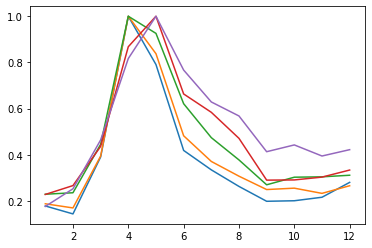

In [120]:
# explore submissions by user group in each month

# Get pivot table
engagement = pd.DataFrame(df.groupby(["created_month", "posts_by_user"])["id"].count()).unstack()
engagement.columns = engagement.columns.droplevel()
engagement.columns = engagement.columns.add_categories('created_month')
engagement = engagement.reset_index()
print(engagement)

# normalise columns to put on one chart
# apply the maximum absolute scaling in Pandas using the .abs() and .max() methods
def maximum_absolute_scaling(df, columns):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled
    
# call the maximum_absolute_scaling function
engagement_scaled = maximum_absolute_scaling(engagement, engagement.columns[1:])


# plot lines
x = engagement_scaled["created_month"]

plt.plot(x, engagement_scaled["1"], label = "line 1", linestyle="-") 
plt.plot(x, engagement_scaled["2"], label = "line 2", linestyle="-") 
plt.plot(x, engagement_scaled["3-5"], label = "line 3", linestyle="-")
plt.plot(x, engagement_scaled["6-10"], label = "line 4", linestyle="-")
plt.plot(x, engagement_scaled["11-50"], label = "line 5", linestyle="-")

<AxesSubplot:xlabel='created_month'>

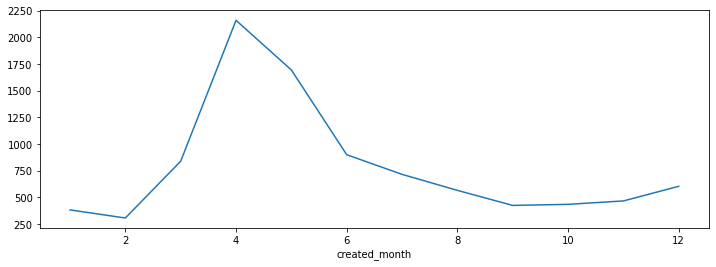

In [75]:
df.loc[df["posts_by_user"]=='1'].groupby("created_month")["author"].nunique().plot(kind='line', figsize=(12,4))

# Text analysis

- [How To Perform Sentiment Analysis in Python 3 Using the Natural Language Toolkit (NLTK)](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk)
- [Sentiment Analysis on Reddit News Headlines with Python’s Natural Language Toolkit (NLTK)](https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/)

## most frequent words

In [6]:
import nltk

from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
#tokenizer.tokenize(example)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def process_text(titles):
    tokens = []
    for line in titles:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [19]:
title_tokens = process_text(df["title_lemmatised"])
word_freq = nltk.FreqDist(title_tokens)

word_freq = word_freq.most_common(25)
word_freq = pd.DataFrame(word_freq, columns=["Word", "Count"])

#export output
word_freq.to_csv(".//data/charts/top25-most-common-words.csv")

word_freq

,Word,Count
0,sourdough,11994
1,loaf,8315
2,first,7841
3,starter,6416
4,bread,4522
5,make,4300
6,get,3710
7,bake,2889
8,pron,2872
9,flour,2747


### word frequency by type of user

In [65]:
lines_1 = list(df.loc[df["posts_by_user"] == '1', "title_lemmatised"])

# run function to process text and return tokens
tokens = process_text(lines_1)

# run frequency distribution and return top 25 words
word_freq = nltk.FreqDist(tokens)
word_freq = word_freq.most_common(25)

#create dataframe
word_freq = pd.DataFrame(word_freq, columns=["Word", "Count"])

#export output
word_freq.to_csv(".//data/charts/top25-most-common-words-user-type-1.csv")

word_freq

,Word,Count
0,first,11873
1,loaf,7881
2,sourdough,7691
3,starter,4015
4,attempt,2408
5,help,1198
6,make,1195
7,bread,1087
8,good,880
9,get,849


In [75]:
lines_2 = list(df.loc[df["posts_by_user"] == '6-10', "title_lemmatised"])

# run function to process text and return tokens
tokens = process_text(lines_2)

# run frequency distribution and return top 25 words
word_freq = nltk.FreqDist(tokens)
word_freq = word_freq.most_common(25)

#create dataframe
word_freq = pd.DataFrame(word_freq, columns=["Word", "Count"])

#export output
word_freq.to_csv(".//data/charts/top25-most-common-words-user-type-6-10.csv")

word_freq

,Word,Count
0,sourdough,2890
1,loaf,2179
2,first,2024
3,starter,1278
4,bread,841
5,good,792
6,get,753
7,make,689
8,bake,649
9,crumb,562


In [71]:
lines_2 = list(df.loc[df["posts_by_user"] == '11-50', "title_lemmatised"])

# run function to process text and return tokens
tokens = process_text(lines_2)

# run frequency distribution and return top 25 words
word_freq = nltk.FreqDist(tokens)
word_freq = word_freq.most_common(25)

#create dataframe
word_freq = pd.DataFrame(word_freq, columns=["Word", "Count"])

#export output
word_freq.to_csv(".//data/charts/top25-most-common-words-user-type-11-50.csv")

word_freq

,Word,Count
0,sourdough,2789
1,loaf,1998
2,first,1648
3,starter,982
4,bake,901
5,bread,816
6,crumb,647
7,get,627
8,make,606
9,today,595


## Sentiment analysis on title using nltk Vader

In [20]:
# classify the sentiment of a post title
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in df["title_lemmatised"]:
    pol_score = sia.polarity_scores(line)
    pol_score['title'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.0, 'title': 'first attempt starter really hope manage keep alive mixed existence open second decade', 'compound': 0.6997, 'neu': 0.655, 'pos': 0.345}, {'neg': 0.178, 'title': 'skillet   dutch oven sourdough rainy pacific northwest', 'compound': -0.0772, 'neu': 0.822, 'pos': 0.0}, {'neg': 0.07, 'title': 'last bread 2019 use brad claire recipe alive sourdough starter smell bit sweet weird bread turn good anyways', 'compound': 0.7783, 'neu': 0.579, 'pos': 0.351}]


In [21]:
# convert results into dataframe
sentiment = pd.DataFrame.from_records(results)

# classify sentiment based on compound value
sentiment['sentiment'] = "neutral"
sentiment.loc[sentiment['compound'] > 0.2, 'sentiment'] = "positive"
sentiment.loc[sentiment['compound'] < -0.2, 'sentiment'] = "negative"

#display dataframe
sentiment.head()

,compound,neg,neu,pos,title,sentiment
0,0.6997,0.000,0.655,0.345,first attempt starter really hope manage keep ...,positive
1,-0.0772,0.178,0.822,0.000,skillet dutch oven sourdough rainy pacific n...,neutral
2,0.7783,0.070,0.579,0.351,last bread 2019 use brad claire recipe alive s...,positive
3,-0.4377,0.212,0.649,0.140,bread come really nice problem oval shape proo...,negative
4,-0.7181,0.333,0.667,0.000,start bake september never happy decision may ...,negative


In [23]:
# merge sentiment to main dataframe
df= pd.merge(df, sentiment, left_on="title_lemmatised", right_on="title")
df.head()

,Unnamed: 0,Unnamed: 0.1,id,score,created_utc,title_x,num_comments,author,created,created_month,...,title_standardised,title_no_stop_words,title_lemmatised,posts_by_user,compound,neg,neu,pos,title_y,sentiment
0,0,0,eibhvl,1,1577839131,"First attempt at a starter, really hope I mana...",5,coentertainer,2020-01-01 00:38:51,1,...,first attempt at a starter really hope i manag...,first attempt starter really hope manage keep ...,first attempt starter really hope manage keep ...,1,0.6997,0.000,0.655,0.345,first attempt starter really hope manage keep ...,positive
1,1,1,eibvur,1,1577841129,Skillet &amp; Dutch Oven Sourdough in the rain...,0,Richness69,2020-01-01 01:12:09,1,...,skillet dutch oven sourdough in the rainy pac...,skillet dutch oven sourdough rainy pacific no...,skillet dutch oven sourdough rainy pacific n...,1,-0.0772,0.178,0.822,0.000,skillet dutch oven sourdough rainy pacific n...,neutral
2,2,2,eiby7m,1,1577841483,My last bread of 2019. I used Brad and Claire’...,0,canioli019,2020-01-01 01:18:03,1,...,my last bread of 2019 i used brad and claire r...,last bread 2019 used brad claire recipe alive ...,last bread 2019 use brad claire recipe alive s...,2,0.7783,0.070,0.579,0.351,last bread 2019 use brad claire recipe alive s...,positive
3,3,276,ektkdp,1,1578313987,"This bread came out really nice, I just have a...",11,canioli019,2020-01-06 12:33:07,1,...,this bread came out really nice i just have a ...,bread came really nice problem oval shape proo...,bread come really nice problem oval shape proo...,2,-0.4377,0.212,0.649,0.140,bread come really nice problem oval shape proo...,negative
4,4,3,eictkk,1,1577846281,I started baking in September and I have never...,0,singular-chip,2020-01-01 02:38:01,1,...,i started baking in september and i have never...,started baking september never happier decisio...,start bake september never happy decision may ...,6-10,-0.7181,0.333,0.667,0.000,start bake september never happy decision may ...,negative


### most frequent positive words

In [24]:
pos_lines = list(df.loc[df["sentiment"] == 'positive', "title_lemmatised"])

# run function to process text and return tokens
pos_tokens = process_text(pos_lines)

# run frequency distribution and return top 25 words
pos_freq = nltk.FreqDist(pos_tokens)
pos_freq = pos_freq.most_common(25)

#create dataframe
pos_freq = pd.DataFrame(pos_freq, columns=["Word", "Count"])

#export output
pos_freq.to_csv(".//data/charts/top25-most-common-words-positive-sentiment.csv")

pos_freq

,Word,Count
0,loaf,5658
1,sourdough,5401
2,first,4364
3,good,3870
4,starter,3813
5,help,3232
6,make,2305
7,bread,2172
8,get,2169
9,yet,1973


### most frequent negative words

In [25]:
neg_lines = list(df.loc[df["sentiment"] == "negative", "title_lemmatised"])

# run function to process text and return tokens
neg_tokens = process_text(neg_lines)

# run frequency distribution and return top 25 words
neg_freq = nltk.FreqDist(neg_tokens)
neg_freq = neg_freq.most_common(25)

#create dataframe
neg_freq = pd.DataFrame(neg_freq, columns=["Word", "Count"])

#export output
neg_freq.to_csv(".//data/charts/top25-most-common-words-negative-sentiment.csv")

neg_freq

,Word,Count
0,starter,1347
1,sourdough,1065
2,wrong,969
3,discard,715
4,first,656
5,loaf,591
6,make,430
7,go,430
8,bread,422
9,kill,369


### sentiment overall

In [34]:
pivot = pd.DataFrame(df["sentiment"].value_counts())
pivot["Percent"] = pivot["sentiment"] / pivot["sentiment"].sum() * 100

#export dataframe
pivot.to_csv(".//data/charts/sentiment-overview.csv")

pivot

,sentiment,Percent
neutral,51389,65.379575
positive,21920,27.887686
negative,5292,6.732739


### Sentiment over time

In [56]:
pivot = df.groupby(["created_month", "sentiment"]).agg({"id":"count"}).unstack()
pivot.columns = pivot.columns.droplevel(level=0)

#export
pivot.to_csv(".//data/charts/sentiment-of-posts-over-time.csv")

# transform to calculate share
pivot = pivot.transpose()
pivot = pivot / pivot.sum(axis=0) *100

#export 
pivot.transpose().to_csv(".//data/charts/sentiment-of-posts-over-time-percent.csv")

### Sentiment by user group

In [64]:
pivot = df.groupby(["posts_by_user", "sentiment"]).agg({"id":"count"}).unstack()
pivot.columns = pivot.columns.droplevel(level=0)

#export
pivot.to_csv(".//data/charts/sentiment-of-posts-by-user-type.csv")

# transform to calculate share
pivot = pivot.transpose()
pivot = pivot / pivot.sum(axis=0) *100

pivot.transpose().to_csv(".//data/charts/sentiment-of-posts-by-user-type-percent.csv")

## Topic analysis